In [ ]:
# Create new dataset
%run ./import_dogs_cats.py

total training cat images: 100
total training dog images: 100
total validation cat images: 50
total validation dog images: 50
total test cat images: 50
total test dog images: 50


In [ ]:
# Base variables
base_dir = '/Users/macbook/book/dogs_cats/data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

train_size, validation_size, test_size = 200, 100, 100

img_width, img_height = 224, 224  # Default input size for VGG16

Using TensorFlow backend.
/Users/macbook/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


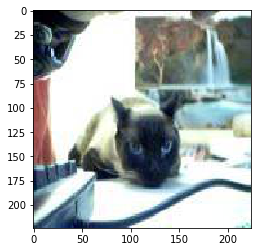

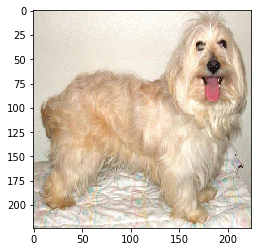

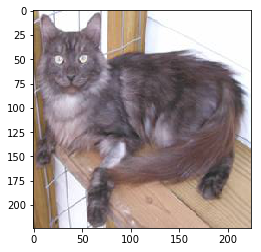

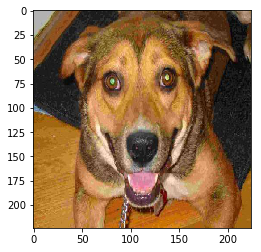

In [ ]:
# Show pictures
import os, random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

def show_pictures(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)

    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()

for i in range(0,2):
    show_pictures(train_cats_dir)
    show_pictures(train_dogs_dir)

In [ ]:
# Instantiate convolutional base
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_width, img_height, 3))  # 3 = number of channels in RGB pictures

In [ ]:
# Check architecture
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [ ]:
# Extract features
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, train_size)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(test_dir, test_size)

Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [ ]:
# Debug
print(train_features)
print(train_labels)

[[[[1.82692751e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.10146582e+00 0.00000000e+00]
   [6.42356634e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.87289083e-01 0.00000000e+00]
   [3.49128097e-01 0.00000000e+00 3.73788565e-01 ... 0.00000000e+00
    7.17178702e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 5.74068189e-01 ... 5.65039366e-02
    8.34508657e-01 0.00000000e+00]
   [4.18749034e-01 0.00000000e+00 4.42826450e-01 ... 0.00000000e+00
    6.61167145e-01 0.00000000e+00]
   [5.59691250e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.63677788e-01 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.62488846e-02
    1.23500705e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 1.78762674e-01 ... 4.78821099e-01
    1.13595152e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 5.44967949e-01 ... 0.00000000e+00
    8.80614758e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 7.61949480e-01 ... 2.35

In [ ]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.Flatten(input_shape=(7,7,512)))
model.add(layers.Dense(256, activation='relu', input_dim=(7*7*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 6,423,041
Trainable params: 6,423,041
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_features, validation_labels))

Train on 200 samples, validate on 100 samples
Epoch 1/100
200/200 [==============================] - 2s - loss: 2.9521 - acc: 0.5900 - val_loss: 2.3528 - val_acc: 0.5000
Epoch 2/100
200/200 [==============================] - 1s - loss: 1.3033 - acc: 0.6850 - val_loss: 0.5219 - val_acc: 0.7000
Epoch 3/100
200/200 [==============================] - 1s - loss: 0.8253 - acc: 0.7550 - val_loss: 0.7768 - val_acc: 0.7600
Epoch 4/100
200/200 [==============================] - 1s - loss: 0.3003 - acc: 0.8850 - val_loss: 0.4023 - val_acc: 0.8100
Epoch 5/100
200/200 [==============================] - 1s - loss: 0.2414 - acc: 0.9000 - val_loss: 0.5071 - val_acc: 0.8000
Epoch 6/100
200/200 [==============================] - 1s - loss: 0.0837 - acc: 0.9650 - val_loss: 0.3704 - val_acc: 0.8600
Epoch 7/100
200/200 [==============================] - 1s - loss: 0.0788 - acc: 0.9750 - val_loss: 0.5023 - val_acc: 0.8100
Epoch 8/100
200/200 [==============================] - 1s - loss: 0.0730 - acc: 0.9800

200/200 [==============================] - 1s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.6030 - val_acc: 0.8400
Epoch 67/100
200/200 [==============================] - 1s - loss: 7.9415e-04 - acc: 1.0000 - val_loss: 0.6067 - val_acc: 0.8400
Epoch 68/100
200/200 [==============================] - 1s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.5961 - val_acc: 0.8400
Epoch 69/100
200/200 [==============================] - 1s - loss: 8.2291e-04 - acc: 1.0000 - val_loss: 0.5929 - val_acc: 0.8400
Epoch 70/100
200/200 [==============================] - 1s - loss: 5.4794e-04 - acc: 1.0000 - val_loss: 0.5917 - val_acc: 0.8400
Epoch 71/100
200/200 [==============================] - 1s - loss: 9.5266e-04 - acc: 1.0000 - val_loss: 0.5964 - val_acc: 0.8500
Epoch 72/100
200/200 [==============================] - 1s - loss: 5.3188e-04 - acc: 1.0000 - val_loss: 0.6002 - val_acc: 0.8500
Epoch 73/100
200/200 [==============================] - 1s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.5970 - val_acc: 

In [ ]:
# Save model
model.save('dogs_cat_fcl.h5')

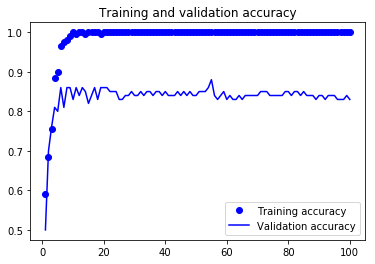

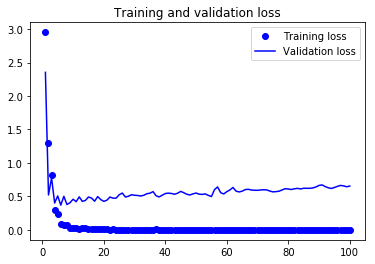

In [ ]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Define function to visualize predictions
def visualize_predictions(classifier, n_cases):
    for i in range(0,n_cases):
        path = random.choice([test_cats_dir, test_dogs_dir])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Extract features
        features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

        # Make prediction
        try:
            prediction = classifier.predict(features)
        except:
            prediction = classifier.predict(features.reshape(1, 7*7*512))

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction < 0.5:
            print('Cat')
        else:
            print('Dog')

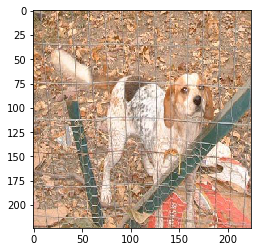

Dog


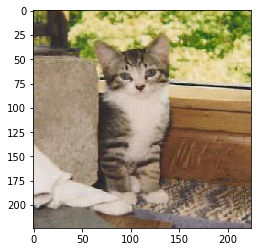

Cat


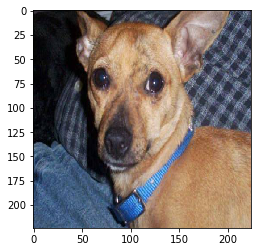

Dog


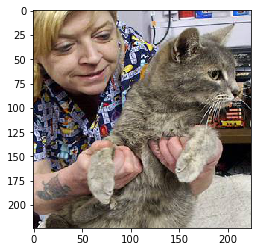

Cat


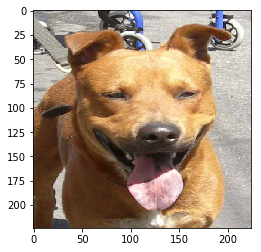

Dog


In [ ]:
# Visualize predictions
visualize_predictions(model, 5)

In [ ]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.GlobalAveragePooling2D(input_shape=(7,7,512)))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_features, validation_labels))

Train on 200 samples, validate on 100 samples
Epoch 1/100
200/200 [==============================] - 0s - loss: 0.7857 - acc: 0.5000 - val_loss: 0.7341 - val_acc: 0.5000
Epoch 2/100
200/200 [==============================] - 0s - loss: 0.7074 - acc: 0.4950 - val_loss: 0.6982 - val_acc: 0.5200
Epoch 3/100
200/200 [==============================] - 0s - loss: 0.6877 - acc: 0.5750 - val_loss: 0.6902 - val_acc: 0.5300
Epoch 4/100
200/200 [==============================] - 0s - loss: 0.6843 - acc: 0.5150 - val_loss: 0.6869 - val_acc: 0.4600
Epoch 5/100
200/200 [==============================] - 0s - loss: 0.6780 - acc: 0.5500 - val_loss: 0.6783 - val_acc: 0.5300
Epoch 6/100
200/200 [==============================] - 0s - loss: 0.6674 - acc: 0.6150 - val_loss: 0.6678 - val_acc: 0.6100
Epoch 7/100
200/200 [==============================] - 0s - loss: 0.6570 - acc: 0.7000 - val_loss: 0.6600 - val_acc: 0.6500
Epoch 8/100
200/200 [==============================] - 0s - loss: 0.6493 - acc: 0.7200

200/200 [==============================] - 0s - loss: 0.4146 - acc: 0.8900 - val_loss: 0.4638 - val_acc: 0.8600
Epoch 66/100
200/200 [==============================] - 0s - loss: 0.4132 - acc: 0.9000 - val_loss: 0.4617 - val_acc: 0.8500
Epoch 67/100
200/200 [==============================] - 0s - loss: 0.4102 - acc: 0.9050 - val_loss: 0.4605 - val_acc: 0.8600
Epoch 68/100
200/200 [==============================] - 0s - loss: 0.4079 - acc: 0.9000 - val_loss: 0.4587 - val_acc: 0.8600
Epoch 69/100
200/200 [==============================] - 0s - loss: 0.4060 - acc: 0.9100 - val_loss: 0.4570 - val_acc: 0.8500
Epoch 70/100
200/200 [==============================] - 0s - loss: 0.4039 - acc: 0.9150 - val_loss: 0.4551 - val_acc: 0.8600
Epoch 71/100
200/200 [==============================] - 0s - loss: 0.4013 - acc: 0.9100 - val_loss: 0.4535 - val_acc: 0.8500
Epoch 72/100
200/200 [==============================] - 0s - loss: 0.4001 - acc: 0.9100 - val_loss: 0.4525 - val_acc: 0.8500
Epoch 73/100


In [ ]:
# Save model
model.save('dogs_cat_gap.h5')

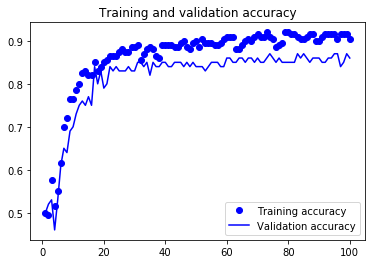

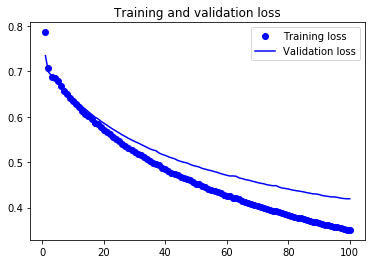

In [ ]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

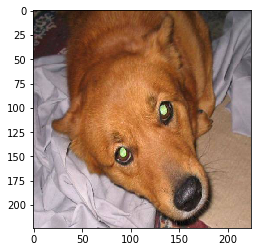

Dog


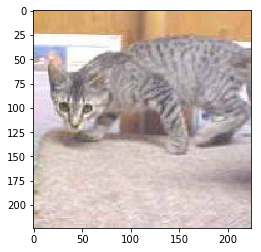

Cat


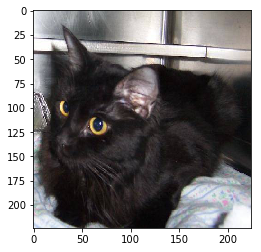

Cat


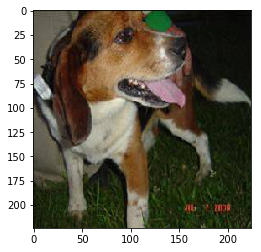

Dog


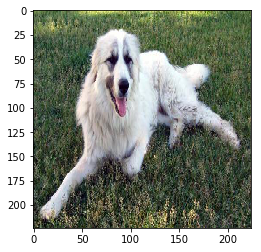

Dog


In [ ]:
# Visualize predictions
visualize_predictions(model, 5)

In [ ]:
# Concatenate training and validation sets
svm_features = np.concatenate((train_features, validation_features))
svm_labels = np.concatenate((train_labels, validation_labels))

In [ ]:
# Build model
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.svm import LinearSVC

X_train, y_train = svm_features.reshape(300,7*7*512), svm_labels

param = [{
          "C": [0.01, 0.1, 1, 10, 100]
         }]

svm = LinearSVC(penalty='l2', loss='squared_hinge')  # As in Tang (2013)
clf = GridSearchCV(svm, param, cv=10)
clf.fit(X_train, y_train)

/Users/macbook/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/macbook/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [ ]:
# Save model
model.save('dogs_cat_svm.h5')

In [ ]:
# Evaluate model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

print("\nAccuracy score (mean):")
print(np.mean(cross_val_score(clf, X_train, y_train, cv=10)))
print("\nAccuracy score (standard deviation):")
print(np.std(cross_val_score(clf, X_train, y_train, cv=10)))


Accuracy score (mean):
0.8600000000000001

Accuracy score (standard deviation):
0.04666666666666666


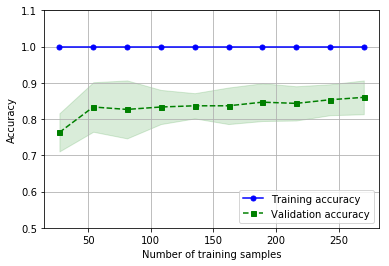

In [ ]:
# Plot learning curves
from sklearn.model_selection import learning_curve
'''
train_sizes, train_scores, test_scores = learning_curve(estimator = clf,
                                                        X = X_train,
                                                        y = y_train,
                                                        train_sizes = np.linspace(0.1,1.0,10),
                                                        cv = 10)
'''
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue',
         marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')


plt.plot(train_sizes, test_mean, color='green', linestyle='--',
         marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.1])
plt.show()

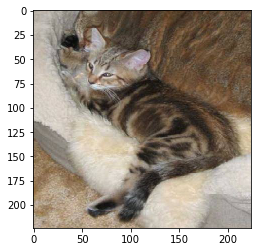

Cat


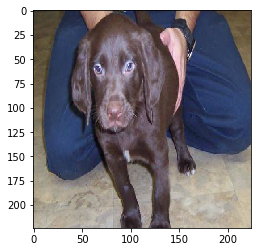

Dog


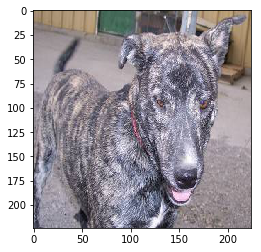

Cat


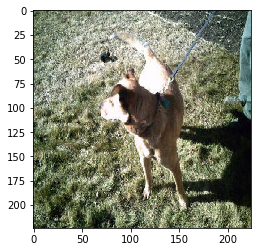

Dog


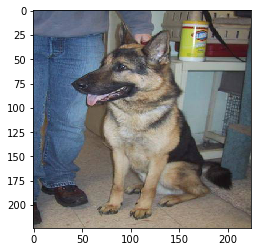

Dog


In [ ]:
# Visualize predictions
visualize_predictions(clf, 5)